# Univariate LSTM - Single asset (in-sample) prediction
## 1. Import Libraries

In [1]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data
import math
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

#LSTM RNN
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

#Check for stationarity
from sklearn.metrics import mean_squared_error

plt.style.use('seaborn-darkgrid')
%matplotlib inline


Using TensorFlow backend.


Some helpful resources

(Multi stock prediction w single nn)[https://www.kaggle.com/humamfauzi/multiple-stock-prediction-using-single-nn]
(LSTM math)[https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235]

Root of mean squared error (helper fn)

In [2]:
def rmse_return(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
#Import single asset: GLD

def GetData(asset_name):
    return pd.read_csv('Asset_Dataset/'+asset_name+'.csv', usecols=['Date','Adj Close'], parse_dates=True, index_col='Date' ).astype('float32').dropna()

def GetVol(asset_name):
    return pd.read_csv('Asset_Dataset/'+asset_name+'.csv', usecols=['Date','Volume'], parse_dates=True, index_col='Date' ).astype('float32').dropna()

Text(0.5, 0, 'Time')

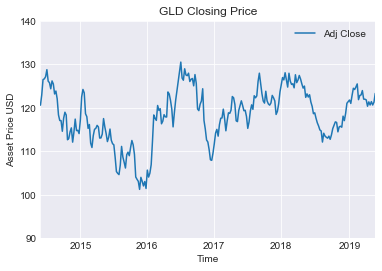

In [4]:
data_GLD = GetData('GLD')
data_GLD.plot()
plt.title('GLD Closing Price')
plt.ylabel('Asset Price USD')
plt.ylim(90,140)
plt.xlabel('Time')

### Univariate LSTM - Single Asset

In [5]:
#train-test split
split_date = '2018-01-01'

train = data_GLD[data_GLD.index<split_date]
test = data_GLD[data_GLD.index>=split_date]

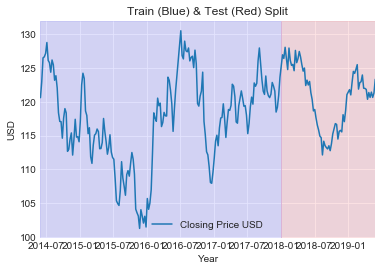

      Training set consists of 72.0% of data


In [6]:
plt.plot(data_GLD)
plt.axvspan(data_GLD.index[0], split_date, color='blue', alpha=0.1)
plt.axvspan(split_date, data_GLD.index[-1], color='red', alpha=0.1)
plt.xlim(data_GLD.index[0],data_GLD.index[-1])
plt.title('Train (Blue) & Test (Red) Split')
plt.legend(['Closing Price USD'])
plt.xlabel('Year')
plt.ylabel('USD')

plt.show()
print('      Training set consists of {}% of data'.format(round(train.shape[0]/data_GLD.shape[0],2)*100))


Use MinMaxScaler() to scale NN values to between 0,1. Then, reshape to ensure shape match.
* Q is the week-ahead for prediction

In [7]:
mm = MinMaxScaler()

train = np.reshape(train.values, (len(train), 1))
train = mm.fit_transform(train)

test = np.reshape(test.values, (len(test),1))
test = mm.transform(test)

Q = 1
X_train = train[0:len(train)-Q]
y_train = train[Q:len(train)]

X_test = test[0:len(test)-Q]
y_test = test[Q:len(test)]

X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

* defines early stopping patience and lstm node count
* use MSE instead of MAE due to potentially small spread in errors

In [8]:
patience = 15
lstm_nodes = 32

In [9]:
Univar_LSTM = 'reset'
# designing NN
Univar_LSTM = Sequential()
Univar_LSTM.add(LSTM(lstm_nodes, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
Univar_LSTM.add(Dense(1))
Univar_LSTM.compile(optimizer='adam', loss='mse')
# fit NN
history_univar = Univar_LSTM.fit(X_train, y_train, batch_size=1, epochs=100, 
                           validation_data=(X_test, y_test), callbacks = [EarlyStopping(monitor='val_loss', patience=patience)],
                          verbose=-1)

W0819 10:53:58.731559 4692530624 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 10:53:58.760600 4692530624 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 10:53:58.762951 4692530624 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0819 10:53:59.011720 4692530624 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0819 10:53:59.198889 4692530624 deprecation.py:323] From //anaconda3/li

Train on 186 samples, validate on 73 samples
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100


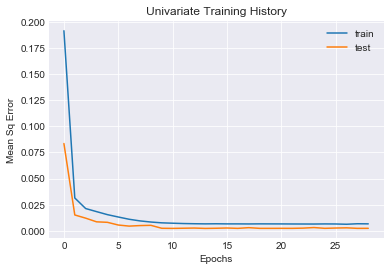

In [10]:
# plot history
plt.plot(history_univar.history['loss'], label='train')
plt.plot(history_univar.history['val_loss'], label='test')
plt.title('Univariate Training History')
plt.xlabel('Epochs')
plt.ylabel('Mean Sq Error')
plt.legend()
plt.show()

In [11]:
#finding predictions for testing data
predicted_univar = Univar_LSTM.predict(X_test)
predicted_univar = mm.inverse_transform(predicted_univar)[:,0]

y_true = mm.inverse_transform(y_test)

In [12]:
#building dataframe of predictions values
pred = pd.DataFrame({'True':y_true.flatten(),'Pred_Univar':predicted_univar.flatten()})
pred.index = data_GLD[data_GLD.index>=split_date][:-1].index

In [13]:
#percent change per day, difference between
change_pct = pred.pct_change()[1:]
change_pct = change_pct[1:]
change_pct['Univar'] = change_pct['True'] - change_pct['Pred_Univar']
change_pct['Tru'] = 0
change_pct.index = data_GLD[data_GLD.index>=split_date][1:-2].index

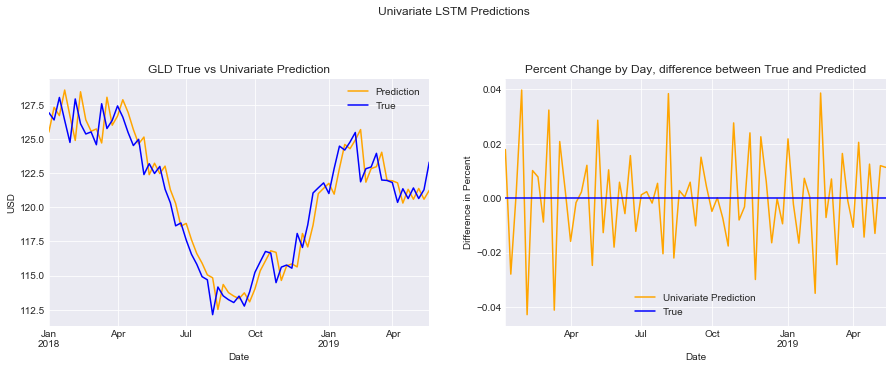

In [14]:
fig = plt.figure(figsize=[15, 10])
plt.suptitle('Univariate LSTM Predictions')

plt.subplot(221)
pred.Pred_Univar.plot(c='orange')
pred['True'].plot(c='blue')
plt.legend(['Prediction','True'])
plt.title('GLD True vs Univariate Prediction')
plt.ylabel('USD')
plt.xlabel('Date')

plt.subplot(222)
plt.title('Percent Change by Day, difference between True and Predicted')
plt.ylabel('Difference in Percent')
plt.xlabel('Date')
change_pct.Univar.plot(c='orange')
change_pct.Tru.plot(c= 'blue')
plt.legend(['Univariate Prediction','True']);
plt.show()

Observations:
* Univariate LSTM tends to under-estimate GLD values
* To rectify:
    * Increase the number of features
    * Increase the training to overcome over- or under-fitting

# MULTIVARIATE LSTM - Single asset (in-sample) prediction
## Use Adj Close Price, Volume, Savings Rate, and VIX to engineer the features

In [15]:
#import market and econ data
%store -r data_gdp
%store -r data_savings
%store -r data_vix

In [16]:
GLD_vol = GetVol('GLD')

In [17]:
#market and econ data
#fill using previous values
data_m = pd.concat([data_savings,data_vix],axis=1)
data_m = data_m.fillna(method='ffill')

In [18]:
data_all = pd.concat([data_GLD,GLD_vol,data_m],axis=1).dropna()
data_all.columns = ['Adj_Close','Volume','Savings','VIX']
data_all.head()

,Adj_Close,Volume,Savings,VIX
Date,,,,
2014-06-02,120.610001,23772000.0,7.5,11.58
2014-06-09,122.959999,21332000.0,7.5,11.15
2014-06-16,126.500000,48796800.0,7.5,12.65
2014-06-23,126.660004,27915400.0,7.5,10.98
2014-06-30,127.160004,36930700.0,7.5,11.57


In [19]:
data_all['Close_diff'] = data_all['Adj_Close'] - data_all['Adj_Close'].shift(-1)
data_all['Vol_diff'] = data_all['Volume'] - data_all['Volume'].shift(-1)
data_all['Savings_diff'] = data_all['Savings'] - data_all['Savings'].shift(-1)
data_all['Vix_diff'] = data_all['VIX'] - data_all['VIX'].shift(-1)
data_all.dropna()


,Adj_Close,Volume,Savings,VIX,Close_diff,Vol_diff,Savings_diff,Vix_diff
Date,,,,,,,,
2014-06-02,120.610001,23772000.0,7.5,11.580000,-2.349998,2440000.0,0.0,0.430000
2014-06-09,122.959999,21332000.0,7.5,11.150000,-3.540001,-27464800.0,0.0,-1.500000
2014-06-16,126.500000,48796800.0,7.5,12.650000,-0.160004,20881400.0,0.0,1.670000
2014-06-23,126.660004,27915400.0,7.5,10.980000,-0.500000,-9015300.0,0.0,-0.590000
2014-06-30,127.160004,36930700.0,7.5,11.570000,-1.619995,7085800.0,0.0,0.240000
2014-07-07,128.779999,29844900.0,7.5,11.330000,2.650002,-14146900.0,0.0,-0.490000
2014-07-14,126.129997,43991800.0,7.5,11.820000,0.339996,20021700.0,0.0,-0.990000
2014-07-21,125.790001,23970100.0,7.5,12.810000,1.410004,-7418800.0,0.0,0.250000
2014-07-28,124.379997,31388900.0,7.5,12.560000,-1.810005,-5807900.0,0.2,-2.560000


In [20]:
def diff_col(df ,col_name,delta):
     return  (df[col_name].shift(delta) - df[col_name]).shift(-delta)
def diff_inverse_col(df,col_name,delta, diff_col):
    return (df[col_name].shift(delta) - diff_col.shift(delta))

In [21]:
temp_data_all = data_all
temp_data_all['Close_shift_t+1'] = data_all['Adj_Close'].shift(-1)
temp_data_all.dropna()

,Adj_Close,Volume,Savings,VIX,Close_diff,Vol_diff,Savings_diff,Vix_diff,Close_shift_t+1
Date,,,,,,,,,
2014-06-02,120.610001,23772000.0,7.5,11.580000,-2.349998,2440000.0,0.0,0.430000,122.959999
2014-06-09,122.959999,21332000.0,7.5,11.150000,-3.540001,-27464800.0,0.0,-1.500000,126.500000
2014-06-16,126.500000,48796800.0,7.5,12.650000,-0.160004,20881400.0,0.0,1.670000,126.660004
2014-06-23,126.660004,27915400.0,7.5,10.980000,-0.500000,-9015300.0,0.0,-0.590000,127.160004
2014-06-30,127.160004,36930700.0,7.5,11.570000,-1.619995,7085800.0,0.0,0.240000,128.779999
2014-07-07,128.779999,29844900.0,7.5,11.330000,2.650002,-14146900.0,0.0,-0.490000,126.129997
2014-07-14,126.129997,43991800.0,7.5,11.820000,0.339996,20021700.0,0.0,-0.990000,125.790001
2014-07-21,125.790001,23970100.0,7.5,12.810000,1.410004,-7418800.0,0.0,0.250000,124.379997
2014-07-28,124.379997,31388900.0,7.5,12.560000,-1.810005,-5807900.0,0.2,-2.560000,126.190002


In [21]:
# convert time series to supervised learning
# Using one lag observation as input (x)
# Using one observation as output (y)
def convert_ts_to_supervised(data_in):
    n_vars = 1 if type(data_in) is list else data_all.shape[1]
    df = pd.DataFrame(data_in)
    y = list()
    names = list()
    # Build input sequence
    y.append(df.shift(1))
    names += [('var%d(t-%d)' % (j+1, 1)) for j in range(n_vars)]
    
    # Build forecast sequence 
    y.append(df.shift(-1))
    names += [('var%d(t+%d)' % (j+1, 1)) for j in range(n_vars)]
    
    # Combine input and forecast sequence
    combined_data = pd.concat(y, axis=1)
    combined_data.columns = names

    # Remove missing values
    combined_data.dropna(inplace=True)
    return combined_data


In [22]:
def plot_features(data):
    # Plot only the features:
    # GLD_close price, Savings, VIX_close price
    num_features = [0, 1, 2]
    i = 1
    pyplot.figure(figsize=(10,8))
    for n in num_features:
        pyplot.subplot(len(num_features), 1, i)
        pyplot.plot(values[:, n])
        pyplot.title(data.columns[n], y=0.6, loc='left')
        i += 1
    pyplot.show()


In [23]:
#Engineer the features: normalization and transformation
scaler = MinMaxScaler(feature_range=(0,1))
scaled_in = scaler.fit_transform(data_all)
print(scaled_in)

[[0.69816097 0.08928237 0.48       ... 0.52584354 0.76190476 0.70322256]
 [0.78290669 0.0675301  0.48       ... 0.29275676 0.76190476 0.65500873]
 [0.91056631 0.31237508 0.48       ... 0.66958121 0.76190476 0.73419933]
 ...
 [0.72773182 0.06698273 0.68       ... 0.36143072 0.76190476 0.5648264 ]
 [0.69960348 0.23328062 0.68       ... 0.65968792 0.76190476 0.79840117]
 [0.72304386 0.0584414  0.68       ...        nan        nan        nan]]


In [24]:
#Convert TS to supervised learning model
reframed = convert_ts_to_supervised(scaled_in)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.698161   0.089282       0.48   0.071338   0.289609   0.525844   
2   0.782907   0.067530       0.48   0.057643   0.201916   0.292757   
3   0.910566   0.312375       0.48   0.105414   0.450994   0.669581   
4   0.916336   0.126220       0.48   0.052229   0.425939   0.436558   
5   0.934367   0.206590       0.48   0.071019   0.343405   0.562054   

   var7(t-1)  var8(t-1)  var1(t+1)  var2(t+1)  var3(t+1)  var4(t+1)  \
1   0.761905   0.703223   0.910566   0.312375       0.48   0.105414   
2   0.761905   0.655009   0.916336   0.126220       0.48   0.052229   
3   0.761905   0.734199   0.934367   0.206590       0.48   0.071019   
4   0.761905   0.677742   0.992788   0.143421       0.48   0.063376   
5   0.761905   0.698476   0.897223   0.269539       0.48   0.078981   

   var5(t+1)  var6(t+1)  var7(t+1)  var8(t+1)  
1   0.450994   0.669581   0.761905   0.734199  
2   0.425939   0.436558   0.761905   0.677742  
3 

In [25]:
# Predict only y=GLD_Close(t+1)
# Drop columns Savings(t+1) and VIX_Close(t+1)
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var7(t-1)  var8(t-1)  \
1   0.698161   0.089282       0.48   0.071338   0.761905   0.703223   
2   0.782907   0.067530       0.48   0.057643   0.761905   0.655009   
3   0.910566   0.312375       0.48   0.105414   0.761905   0.734199   
4   0.916336   0.126220       0.48   0.052229   0.761905   0.677742   
5   0.934367   0.206590       0.48   0.071019   0.761905   0.698476   

   var1(t+1)  var2(t+1)  var3(t+1)  var4(t+1)  var5(t+1)  var6(t+1)  \
1   0.910566   0.312375       0.48   0.105414   0.450994   0.669581   
2   0.916336   0.126220       0.48   0.052229   0.425939   0.436558   
3   0.934367   0.206590       0.48   0.071019   0.343405   0.562054   
4   0.992788   0.143421       0.48   0.063376   0.658069   0.396560   
5   0.897223   0.269539       0.48   0.078981   0.487840   0.662880   

   var7(t+1)  var8(t+1)  
1   0.761905   0.734199  
2   0.761905   0.677742  
3   0.761905   0.698476  
4   0.761905   0.680240  
5   0.761905   0

In [27]:
# Split into 80% train and 20% test data
values = reframed.values
train_80pct = int(len(values)* 0.8)


In [28]:
train = values[:train_80pct, :]
test = values[train_80pct:, :]

In [29]:
# Split training and test data into input(x) and output(y)
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [30]:
# Reshape for LSTM network: [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [31]:
# Design network and fit the model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
fitted = model.fit(train_X, train_y, epochs=200, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 188 samples, validate on 47 samples
Epoch 1/200
 - 2s - loss: 0.4313 - val_loss: 0.4137
Epoch 2/200
 - 0s - loss: 0.3882 - val_loss: 0.3683
Epoch 3/200
 - 0s - loss: 0.3476 - val_loss: 0.3258
Epoch 4/200
 - 0s - loss: 0.3094 - val_loss: 0.2860
Epoch 5/200
 - 0s - loss: 0.2736 - val_loss: 0.2488
Epoch 6/200
 - 0s - loss: 0.2401 - val_loss: 0.2144
Epoch 7/200
 - 0s - loss: 0.2088 - val_loss: 0.1826
Epoch 8/200
 - 0s - loss: 0.1799 - val_loss: 0.1535
Epoch 9/200
 - 0s - loss: 0.1533 - val_loss: 0.1271
Epoch 10/200
 - 0s - loss: 0.1290 - val_loss: 0.1034
Epoch 11/200
 - 0s - loss: 0.1071 - val_loss: 0.0826
Epoch 12/200
 - 0s - loss: 0.0877 - val_loss: 0.0644
Epoch 13/200
 - 0s - loss: 0.0706 - val_loss: 0.0491
Epoch 14/200
 - 0s - loss: 0.0559 - val_loss: 0.0365
Epoch 15/200
 - 0s - loss: 0.0436 - val_loss: 0.0265
Epoch 16/200
 - 0s - loss: 0.0337 - val_loss: 0.0191
Epoch 17/200
 - 0s - loss: 0.0259 - val_loss: 0.0139
Epoch 18/200
 - 0s - loss: 0.0201 - val_loss: 0.0108
Epoch 19/2

Epoch 154/200
 - 0s - loss: 0.0085 - val_loss: 0.0085
Epoch 155/200
 - 0s - loss: 0.0085 - val_loss: 0.0085
Epoch 156/200
 - 0s - loss: 0.0084 - val_loss: 0.0085
Epoch 157/200
 - 0s - loss: 0.0084 - val_loss: 0.0085
Epoch 158/200
 - 0s - loss: 0.0084 - val_loss: 0.0084
Epoch 159/200
 - 0s - loss: 0.0084 - val_loss: 0.0084
Epoch 160/200
 - 0s - loss: 0.0084 - val_loss: 0.0084
Epoch 161/200
 - 0s - loss: 0.0084 - val_loss: 0.0084
Epoch 162/200
 - 0s - loss: 0.0083 - val_loss: 0.0084
Epoch 163/200
 - 0s - loss: 0.0083 - val_loss: 0.0084
Epoch 164/200
 - 0s - loss: 0.0083 - val_loss: 0.0083
Epoch 165/200
 - 0s - loss: 0.0083 - val_loss: 0.0083
Epoch 166/200
 - 0s - loss: 0.0083 - val_loss: 0.0083
Epoch 167/200
 - 0s - loss: 0.0083 - val_loss: 0.0083
Epoch 168/200
 - 0s - loss: 0.0082 - val_loss: 0.0083
Epoch 169/200
 - 0s - loss: 0.0082 - val_loss: 0.0083
Epoch 170/200
 - 0s - loss: 0.0082 - val_loss: 0.0083
Epoch 171/200
 - 0s - loss: 0.0082 - val_loss: 0.0082
Epoch 172/200
 - 0s - loss: 

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                12800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 12,851
Trainable params: 12,851
Non-trainable params: 0
_________________________________________________________________


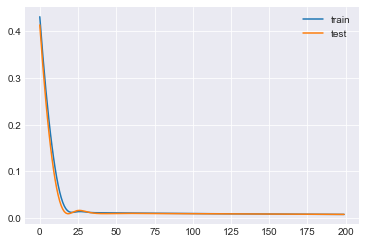

In [33]:
# Plot istory
plt.plot(fitted.history['loss'], label='train')
plt.plot(fitted.history['val_loss'], label='test')
plt.legend()
plt.show()

In [34]:
# Predict SP500 Close Price
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [36]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = mm.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [37]:
# Reverse scaling to get actual value
test_y = test_y.reshape((len(test_y), 1))
rev_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
rev_y = mm.inverse_transform(rev_y)
rev_y = rev_y[:,0]
print (rev_y)

[121.80407858 121.54815799 117.84827756 122.78388881 123.64670678
 121.41654169 121.67246228 120.31973919 123.70520291 118.95239207
 123.19336174 121.76020648 120.05650659 121.86988673 122.60108839
 121.66515026 118.82077577 117.41686931 122.73270469 117.81902803
 124.98480729 121.16061965 121.77483124 122.39635193 123.31766529
 116.98546105 120.14425006 113.07353067 129.30620768 124.45834063
 123.22260981 121.66514953 123.81488389 121.34342153 122.33785579
 121.67977429 121.73827043 122.41828798 119.15712854 123.66133081
 121.67977429 122.14774336 121.44578976 121.01438078 119.81521004
 117.78247014 124.61920499]


In [38]:
# Calculate and print RMSE
rmse = math.sqrt(mean_squared_error(rev_y, inv_yhat))
print('RMSE Result: %.5f' % rmse)

RMSE Result: 2.59136


In [ ]:
#finding predictions for testing data
predicted_univar = Univar_LSTM.predict(X_test)
predicted_univar = mm.inverse_transform(predicted_univar)[:,0]

y_true = mm.inverse_transform(y_test)

In [ ]:
#building dataframe of predictions values
pred = pd.DataFrame({'True':y_true.flatten(),'Pred_Univar':predicted_univar.flatten()})
pred.index = data_GLD[data_GLD.index>=split_date][:-1].index

In [ ]:
#percent change per day, difference between
change_pct = pred.pct_change()[1:]
change_pct = change_pct[1:]
change_pct['Univar'] = change_pct['True'] - change_pct['Pred_Univar']
change_pct['Tru'] = 0
change_pct.index = data_GLD[data_GLD.index>=split_date][1:-2].index

In [ ]:
fig = plt.figure(figsize=[15, 10])
plt.suptitle('Multivariate LSTM Predictions')

plt.subplot(221)
pred.Pred_Univar.plot(c='orange')
pred['True'].plot(c='blue')
plt.legend(['Prediction','True'])
plt.title('GLD True vs Univariate Prediction')
plt.ylabel('USD')
plt.xlabel('Date')

plt.subplot(222)
plt.title('Percent Change by Day, difference between True and Predicted')
plt.ylabel('Difference in Percent')
plt.xlabel('Date')
change_pct.Univar.plot(c='orange')
change_pct.Tru.plot(c= 'blue')
plt.legend(['Univariate Prediction','True']);
plt.show()